# Doc 2 Curb Weight Data

Curb weight data source: https://xl.16888.com/style-202503-202503-1.html
- Vehicle type coverage: micro, small, compact, mid-size, large, luxury, MPV, and SUV.
- Not include imported models.
- Car sales data from 2007 to present.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1 Extraction

In [ ]:
import pandas as pd
from tqdm import tqdm
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
# automate download
from selenium.webdriver.chrome.service import Service
driver_path=ChromeDriverManager().install()

def init_driver():
    service = Service(driver_path)
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])
    prefs = {"profile.managed_default_content_settings.images": 2, 'permissions.default.stylesheet': 2}
    chrome_options.add_experimental_option("prefs", prefs)
    chrome_options.add_argument('lang=zh_CN.utf-8')
    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

def get_model_year(year):
    """
    Get model sales data of one year.
    """
    url = 'https://xl.16888.com/style-%d01-%d12-1.html' % (year, year)
    driver = init_driver()
    try:
        driver.get(url)
    except:
        print("No Data.")
    wait = WebDriverWait(driver, 10)
    # define data file
    data = []
    page = 1
    # iterate pages
    while True:
        # get items
        table = driver.find_element(By.CSS_SELECTOR, 'body > div:nth-child(5) > div.xl-section.clr > div.xl-section-r.fr > div > div.xl-table-view > div.xl-table-data > table > tbody')
        rows = table.find_elements(By.TAG_NAME, 'tr')
        for row in rows:
            # sales data
            cells = row.find_elements(By.TAG_NAME, 'td')
            line = [cell.text for cell in cells[:-1]]
            if line:
                model = line[1]
                sale = line[2]
                data.append([model, sale])
        page += 1
        try:
            # wait for next page botton
            next_page = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'a.lineBlock.next')))
            # click next page
            next_page.click()
            # wait for next page
            wait.until(EC.staleness_of(next_page))
        except:
            print('All pages done!')
            break
    driver.close()
    df = pd.DataFrame(data, columns=['model', 'sales'])
    df['class'] = None
    df['fuel'] = None
    df['weight'] = None
    df['frontB'] = None
    df['rearB'] = None
    df['link'] = None
    return df

def get_model_link(df):
    """
    Get config link of models.
    """
    url = 'https://auto.16888.com/'
    driver = init_driver()
    try:
        driver.get(url)
    except:
        print("No Data.")
    wait = WebDriverWait(driver, 10)
    for i in tqdm(range(df.shape[0])):
        # get link
        line = df.loc[i]
        try:
            link = driver.find_element(By.LINK_TEXT, line['model'])
            link = link.get_attribute('href')
            df.loc[i, 'link'] = link
        except:
            pass
    driver.close()
    return df

def get_model_config(df, year):
    """
    Get config data of models.
    """
    df['year'] = year
    # initialize driver
    for i in tqdm(range(df.shape[0])):
        link = df.loc[i, 'link']
        if link:
            n = 0
            while True:
                n += 1
                try:
                    driver = init_driver()
                    driver.get(link)
                    break
                except:
                    if n <= 10:
                        print("Create driver failed. Retry...")
                    else:
                        break
            if n > 10:
                continue
        else:
            continue
        # get config data
        try:
            link = driver.find_element(By.LINK_TEXT, '参数配置')
            link.click()
        except:
            continue
        # select a year
        find_status = 0
        for y in list(range(year, 2025, 1)):
            try:
                type_year = driver.find_element(By.XPATH, '//*[@id="Year%d"]' % y) 
                type_year.click()
                find_status = 1
                break
            except:
                pass
        if find_status == 0:
            for y in list(range(year, 2000, -1)):
                try:
                    type_year = driver.find_element(By.XPATH, '//*[@id="Year%d"]' % y) 
                    type_year.click()
                    find_status = 1
                    break
                except:
                    pass
        if find_status == 1:
            config_table = driver.find_element(By.ID, 'config_main')  # data table
            config_data = config_table.text
            # config data extraction
            config_data = config_data.split('\n')
            car_class = config_data[5].split()[1:]
            fuel_type = config_data[49].split()[1:]
            weight = config_data[26].split()[1:]
            front_brake = config_data[66].split()[1:]
            rear_brake = config_data[67].split()[1:]
            # save
            df.loc[i, 'fuel'] = str(fuel_type)
            df.loc[i, 'class'] = str(car_class)
            df.loc[i, 'weight'] = str(weight)
            df.loc[i, 'frontB'] = str(front_brake)
            df.loc[i, 'rearB'] = str(rear_brake)
        else:
            pass
        driver.close()
    return df

In [ ]:
# aggregate function
def get_sales(year):
    df = get_model_year(year)
    df = get_model_link(df)
    df = get_model_config(df, year)
    return df

In [ ]:
# crawling data from 2007 to 2025
for year in range(2007,2025,1):
    try:
        sales = get_model_year(int(year))
        sales = get_model_link(sales)
        sales = get_model_config(sales, int(year))
        sales.to_excel("data/car_sale_%d.xlsx" % year, index=False)
    except:
        pass

## 2 Processing

In [14]:
# processing functions
# for model with multiple parameters, we choose the most common or typical set of params
def get_basic_weight(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = [s for s in data if any(char.isdigit() for char in s)]
    if data:
        data = max(data,key=data.count)
        return int(data)
    else:
        return None

def get_basic_brake(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if '通风盘式' in data:
        return 'ventiled'
    elif '盘式' in data:
        return 'disc'
    elif '鼓式' in data:
        return 'drum'
    else:
        return None

# vehicle class
car_map = {
    'SUV': 'SUV', 
    'MPV': 'MPV',
    '微型车': 'minicompact (A00)',
    '小型车': 'subcompact (A0)',
    '紧凑型车': 'compact (A)',
    '中型车': 'midsize (B)',
    '中大型车': 'large (C)',
    '大型车': 'luxury (D)',
}

def get_class(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    data = max(data,key=data.count)
    if data:
        for k,v in car_map.items():
            if k in data:
                return v
        return 'others'
    else:
        return None

def get_fuel_type(x):
    data = str(x).strip('[]').replace('\'', '').replace('/', ',').replace('●', ',').replace(' ', '').split(',')
    if len(data) == 2:
        data = data[0] + data[1]
    else:
        data = max(data,key=data.count)
    if '汽油' in data:
        return 'ICEV'
    elif '纯电' in data:
        return 'BEV'
    elif '插电' in data:
        return 'PHEV'
    elif '混' in data:
        return 'HEV'
    elif '增程' in data:
        return 'EREV'
    else:
        return 'others'

In [15]:
import pandas as pd

# aggregate
sales = pd.DataFrame([])
for year in range(2007, 2025, 1):
    raw = pd.read_excel('data/sales data 2007_2024/car_sale_%d.xlsx' % int(year))
    raw.reset_index(drop=True, inplace=True)
    sale = raw.copy()
    sale['weight'] = sale['weight'].map(get_basic_weight)
    sale['frontB'] = sale['frontB'].map(get_basic_brake)
    sale['rearB'] = sale['rearB'].map(get_basic_brake)
    sale['fuel'] = sale['fuel'].map(get_fuel_type)
    sale['class'] = sale['class'].map(get_class)
    sale['year'] = int(year)
    sales = pd.concat([sales, sale])
# sales.dropna(inplace=True)

In [16]:
sales.head()

,model,sales,class,fuel,weight,frontB,rearB,link,year
0,赛马,849104,subcompact (A0),ICEV,1180.0,disc,drum,https://www.16888.com/57570/,2007
1,远景,813266,compact (A),ICEV,1200.0,ventiled,disc,https://www.16888.com/57609/,2007
2,路宝,707202,minicompact (A00),ICEV,920.0,disc,drum,https://www.16888.com/57568/,2007
3,圣达菲00,691764,SUV,ICEV,1665.0,ventiled,disc,https://www.16888.com/127145/,2007
4,伊兰特,607008,compact (A),ICEV,1250.0,ventiled,disc,https://www.16888.com/58009/,2007


In [19]:
sales.to_excel('data/car_sales_2007_2024.xlsx', index=False)

## 3 Analysis - sales

Models with nan values were further calibrated mannually.

In [21]:
sales = pd.read_excel('data/car_sales_2007_2024_calibration.xlsx')
sales = sales[['year', 'model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB']].copy()

### Merge fuel types

In [22]:
# combine HEV, EREV, and others into ICEV
categories_to_merge = ['ICEV', 'HEV', 'EREV', 'others']
sales['fuel'] = sales['fuel'].apply(
    lambda x: 'ICEV & others' if x in categories_to_merge else x)

### Missing rate

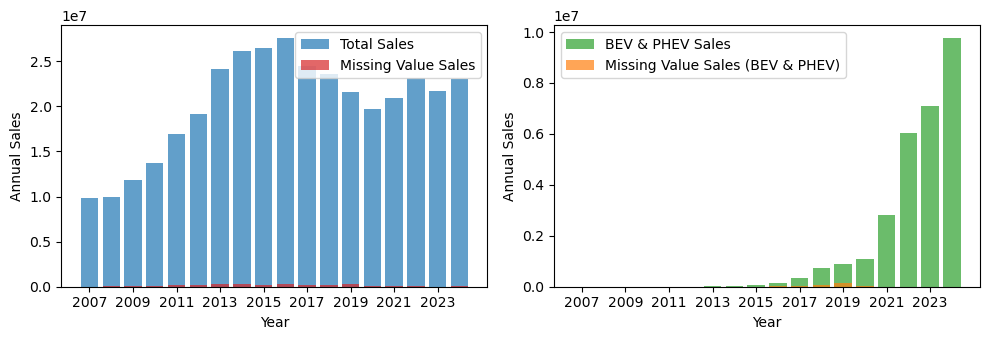

In [35]:
# Identify rows with any missing value in the sales DataFrame
missing_any = sales[sales.isnull().any(axis=1)]
annual_sales = sales.groupby('year')['sales'].sum()
annual_missing_sales = missing_any.groupby('year')['sales'].sum()

# For BEV and PHEV only
bev_phev = sales[sales['fuel'].isin(['BEV', 'PHEV'])]
missing_bev_phev = bev_phev[bev_phev.isnull().any(axis=1)]
annual_bev_phev_sales = bev_phev.groupby('year')['sales'].sum()
annual_missing_bev_phev_sales = missing_bev_phev.groupby('year')['sales'].sum()

# Plotting
fig, axs = plt.subplots(1,2, figsize=(10,3.5), sharex=True)

# First subplot: all models
axs[0].bar(annual_sales.index, annual_sales.values, label='Total Sales', color='tab:blue', alpha=0.7)
axs[0].bar(annual_missing_sales.index, annual_missing_sales.values, label='Missing Value Sales', color='tab:red', alpha=0.7)
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Annual Sales')
axs[0].set_xticks(np.arange(2007, 2025, 2))
axs[0].legend()

# Second subplot: BEV & PHEV only
axs[1].bar(annual_bev_phev_sales.index, annual_bev_phev_sales.values, label='BEV & PHEV Sales', color='tab:green', alpha=0.7)
axs[1].bar(annual_missing_bev_phev_sales.index, annual_missing_bev_phev_sales.values, label='Missing Value Sales (BEV & PHEV)', color='tab:orange', alpha=0.7)
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Annual Sales')
axs[1].set_xticks(np.arange(2007, 2025, 2))
axs[1].legend()

plt.tight_layout()
plt.show()

### Fill missing values

In [23]:
# Fill missing values in 'weight' based on mean for the same year, fuel, and class
sales['weight'] = sales.groupby(['year', 'fuel', 'class'])['weight'].transform(lambda x: x.fillna(x.mean()))

In [24]:
sales.dropna(subset=['model', 'weight'], inplace=True)

### Expand according to sales

In [25]:
# expand according to sales
expanded_data = []
for index, row in sales.iterrows():
    expanded_data.extend([(row['model'], row['sales'], row['class'], row['fuel'], row['weight'], row['frontB'], row['rearB'], row['year'])] * int(row['sales'] / 100))
expanded_sales = pd.DataFrame(expanded_data, columns=['model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB', 'year'])

### Sales-weighted curb weight trend

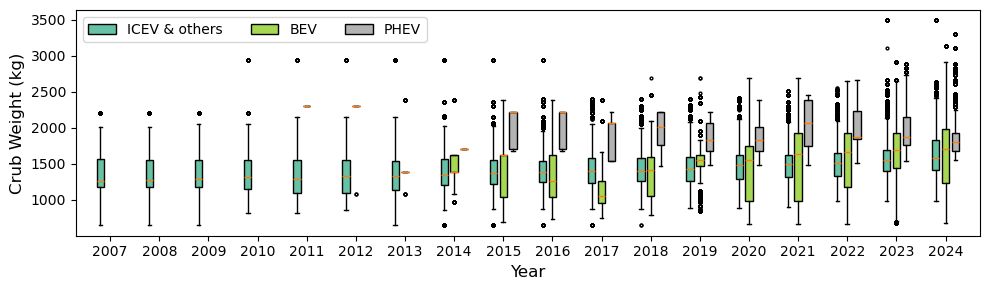

In [40]:
# data preparation
fuels = ['ICEV & others', 'BEV', 'PHEV']
colors = plt.cm.Set2(np.linspace(0, 1, 3))

# get unique years and prepare x positions for boxplots
years = sorted(expanded_sales['year'].unique())
n_years = len(years)
offset = np.array([-0.2, 0, 0.2])
x_positions = np.arange(n_years)[:, np.newaxis] + offset

# draw boxplots
plt.figure(figsize=(10,3))
flierprops = dict(marker='o', markerfacecolor='none', markersize=2, markeredgecolor='black', linestyle='none')
# ICEV
icev_data = [expanded_sales[(expanded_sales['year'] == year) & (expanded_sales['fuel'] == 'ICEV & others')]['weight'].values 
            for year in years]
icev_boxes = plt.boxplot(icev_data, positions=x_positions[:, 0], widths=0.15, patch_artist=True, showfliers=True, flierprops=flierprops)
for box in icev_boxes['boxes']:
    box.set_facecolor(colors[0])

# BEV
bev_data = [expanded_sales[(expanded_sales['year'] == year) & (expanded_sales['fuel'] == 'BEV')]['weight'].values 
           for year in years]
bev_boxes = plt.boxplot(bev_data, positions=x_positions[:, 1], widths=0.15, patch_artist=True, showfliers=True, flierprops=flierprops)
for box in bev_boxes['boxes']:
    box.set_facecolor(colors[1])

# PHEV
phev_data = [expanded_sales[(expanded_sales['year'] == year) & (expanded_sales['fuel'] == 'PHEV')]['weight'].values 
           for year in years]
phev_boxes = plt.boxplot(phev_data, positions=x_positions[:, 2], widths=0.15, patch_artist=True, showfliers=True, flierprops=flierprops)
for box in phev_boxes['boxes']:
    box.set_facecolor(colors[2])

# set x-ticks, labels, and legend
plt.xticks(range(n_years), years)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Crub Weight (kg)', fontsize=12)
legend_labels = ['ICEV & others', 'BEV', 'PHEV']
plt.legend([icev_boxes['boxes'][0], bev_boxes['boxes'][0], phev_boxes['boxes'][0]], 
          legend_labels, loc='upper left', ncol=3)
plt.tight_layout()
plt.show()

### Fuel type distribution trend

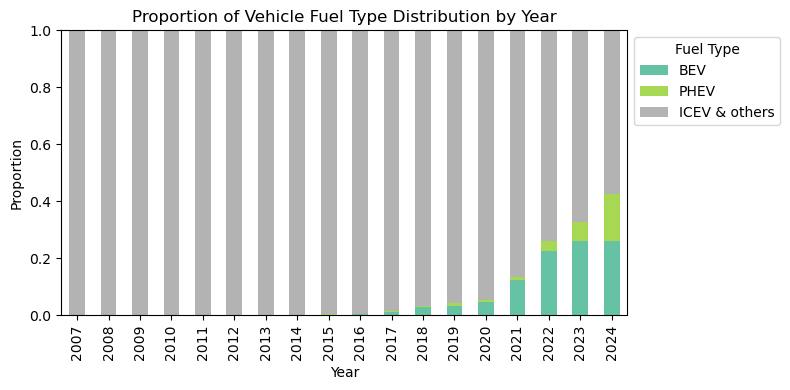

In [43]:
# Normalize to proportions
fuel_type_data = expanded_sales.groupby(['year', 'fuel']).size().unstack(fill_value=0)
fuel_type_data_normalized = fuel_type_data.div(fuel_type_data.sum(axis=1), axis=0)
fuel_type_data_normalized = fuel_type_data_normalized[['BEV', 'PHEV', 'ICEV & others']]

# Plot the stacked barplot
fuel_type_data_normalized.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2', fig=(8, 3))
plt.title('Proportion of Vehicle Fuel Type Distribution by Year')
plt.xlabel('Year')
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.legend(title='Fuel Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

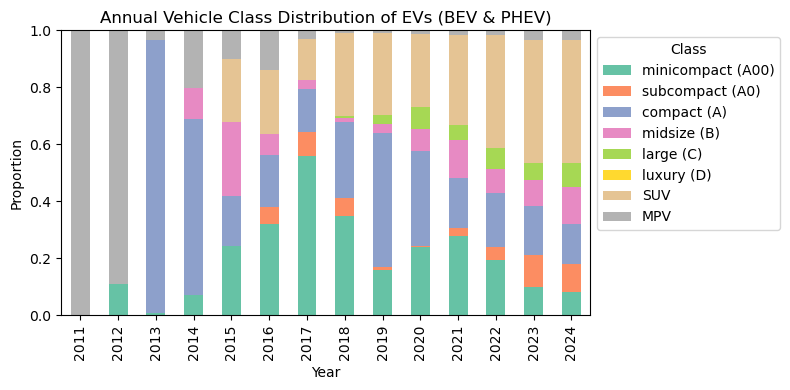

In [105]:
# Prepare data: filter BEV and PHEV, group by year and class, normalize to proportions
ev_expanded = expanded_sales[expanded_sales['fuel'].isin(['BEV', 'PHEV'])]
class_order = ['minicompact (A00)', 'subcompact (A0)', 'compact (A)', 'midsize (B)', 'large (C)', 'luxury (D)', 'SUV', 'MPV']

ev_class_dist = (
    ev_expanded.groupby(['year', 'class'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=class_order, fill_value=0)
)
ev_class_dist_prop = ev_class_dist.div(ev_class_dist.sum(axis=1), axis=0)

# Plot
ev_class_dist_prop.plot(kind='bar', stacked=True, figsize=(8, 4), colormap='Set2')
plt.title('Annual Vehicle Class Distribution of EVs (BEV & PHEV)')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 4 Analysis - population

### Annual fleet profile considering lifetime

In [26]:
# define annual fleets dictionary
annual_fleets = {year: None for year in range(2016, 2025)}

# for each year, filter the expanded_sales DataFrame
for year in range(2016, 2025):
    icev = expanded_sales[
        (expanded_sales['fuel'] == 'ICEV & others') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    bev = expanded_sales[
        (expanded_sales['fuel'] == 'BEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 6)
    ]
    phev = expanded_sales[
        (expanded_sales['fuel'] == 'PHEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
   
    annual_fleets[year] = {
        'ICEV': icev,
        'BEV': bev,
        'PHEV': phev,
    }

In [27]:
population = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV & others': [annual_fleets[year]['ICEV'].shape[0] for year in annual_fleets.keys()],
    'BEV': [annual_fleets[year]['BEV'].shape[0] for year in annual_fleets.keys()],
    'PHEV': [annual_fleets[year]['PHEV'].shape[0] for year in annual_fleets.keys()]
})
population['BEV%'] = population['BEV'] / (population['BEV'] + population['PHEV'])
population['PHEV%'] = population['PHEV'] / (population['BEV'] + population['PHEV'])
population['EV%'] = (population['BEV'] + population['PHEV']) / (population['BEV'] + population['PHEV'] + population['ICEV & others'])
population

,year,ICEV & others,BEV,PHEV,BEV%,PHEV%,EV%
0,2016,1853017,2364,782,0.751430,0.248570,0.001695
1,2017,2093447,5174,1534,0.771318,0.228682,0.003194
2,2018,2321269,11739,2357,0.832789,0.167211,0.006036
3,2019,2527753,18500,4138,0.817210,0.182790,0.008876
4,2020,2616132,27169,5902,0.821535,0.178465,0.012483
5,2021,2697398,52671,8124,0.866371,0.133629,0.022042
6,2022,2748942,103987,16096,0.865959,0.134041,0.041855
7,2023,2757427,157456,30833,0.836246,0.163754,0.063920
8,2024,2720156,211025,68333,0.755393,0.244607,0.093134


### Vehicle weight

In [7]:
penetration = pd.read_excel("data/ev_penetration.xlsx")
penetration = penetration.fillna(method='backfill')

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_19296\1683385587.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  penetration = penetration.fillna(method='backfill')


In [9]:
weights = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV & others': [annual_fleets[year]['ICEV']['weight'].mean() for year in annual_fleets.keys()],
    'BEV': [annual_fleets[year]['BEV']['weight'].mean() for year in annual_fleets.keys()],
    'PHEV': [annual_fleets[year]['PHEV']['weight'].mean() for year in annual_fleets.keys()]
})
weights = pd.merge(weights, penetration[['year', 'bev%']], on='year')
weights['EV'] = weights.apply(lambda x: x['bev%'] * x['BEV'] + (1 - x['bev%']) * x['PHEV'], axis=1)
weights

,year,ICEV & others,BEV,PHEV,bev%,EV
0,2016,1375.485912,1459.397631,2027.549872,0.8120,1566.210252
1,2017,1380.353571,1287.705257,1976.016297,0.8120,1417.107733
2,2018,1385.049715,1343.832207,1969.227577,0.8120,1461.406536
3,2019,1390.412302,1398.794581,1929.503863,0.8120,1498.567926
4,2020,1398.503328,1412.567781,1907.781893,0.8100,1506.658462
5,2021,1406.599983,1452.459231,1940.672173,0.8160,1542.290412
6,2022,1415.529120,1498.356690,1955.013527,0.7980,1590.601371
7,2023,1427.866239,1550.608698,1957.340179,0.7600,1648.224253
8,2024,1444.603455,1585.327999,1931.299778,0.7034,1687.943228


In [10]:
weights.to_csv('data/weights_2016_2024.csv', index=False)

### Model amounts

In [70]:
models = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV & others': [len(annual_fleets[year]['ICEV']['model'].unique()) for year in annual_fleets.keys()],
    'BEV': [len(annual_fleets[year]['BEV']['model'].unique()) for year in annual_fleets.keys()],
    'PHEV': [len(annual_fleets[year]['PHEV']['model'].unique()) for year in annual_fleets.keys()]
})
models

,year,ICEV & others,BEV,PHEV
0,2016,530,19,3
1,2017,624,28,7
2,2018,709,65,18
3,2019,762,98,37
4,2020,815,142,43
5,2021,864,193,54
6,2022,930,264,80
7,2023,965,314,107
8,2024,986,360,150


### Vehicle class

In [72]:
# get yearly class distribution
ev_class_distribution = pd.DataFrame()

for year in range(2016, 2025):
  
    # select valid vehicles based on conditions
    ev_valid_vehicles = pd.concat([annual_fleets[year]['BEV'], annual_fleets[year]['PHEV']])
    
    # calcilate class distribution
    ev_class_counts = ev_valid_vehicles['class'].value_counts().reset_index()
    ev_class_counts.columns = ['class', 'count']
    ev_class_counts['proportion'] = ev_class_counts['count'] / ev_class_counts['count'].sum()
    ev_class_counts['year'] = year
    ev_class_distribution = pd.concat([ev_class_distribution, ev_class_counts], ignore_index=True)

### Class-specific weight

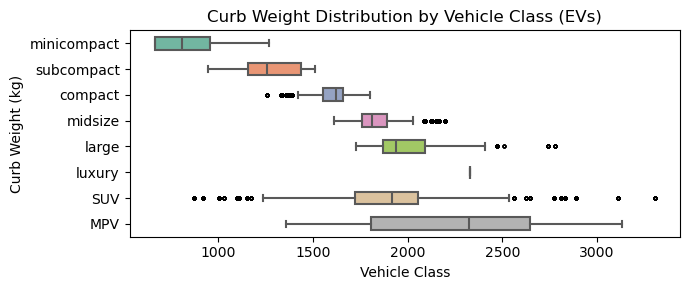

In [99]:
fig, ax = plt.subplots(figsize=(7,3))

# Filter EVs (BEV & PHEV) from expanded_sales
ev_expanded = expanded_sales[expanded_sales['fuel'].isin(['BEV', 'PHEV'])]

# Define the order of vehicle classes for consistent plotting
class_order = ['minicompact (A00)', 'subcompact (A0)', 'compact (A)', 'midsize (B)', 'large (C)', 'luxury (D)', 'SUV', 'MPV']

sns.boxplot(
    ax=ax,
    data=ev_expanded,
    y='class',
    x='weight',
    width=0.5, 
    orient='h',
    order=class_order,
    palette='Set2',
    showfliers=True,
    flierprops=flierprops
)
ax.set_yticklabels(['minicompact', 'subcompact', 'compact', 'midsize', 'large', 'luxury', 'SUV', 'MPV'])
plt.xlabel('Vehicle Class')
plt.ylabel('Curb Weight (kg)')
plt.title('Curb Weight Distribution by Vehicle Class (EVs)')
plt.tight_layout()
plt.show()

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_4456\3495162652.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_cmap = cm.get_cmap('Set2')
C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_4456\3495162652.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


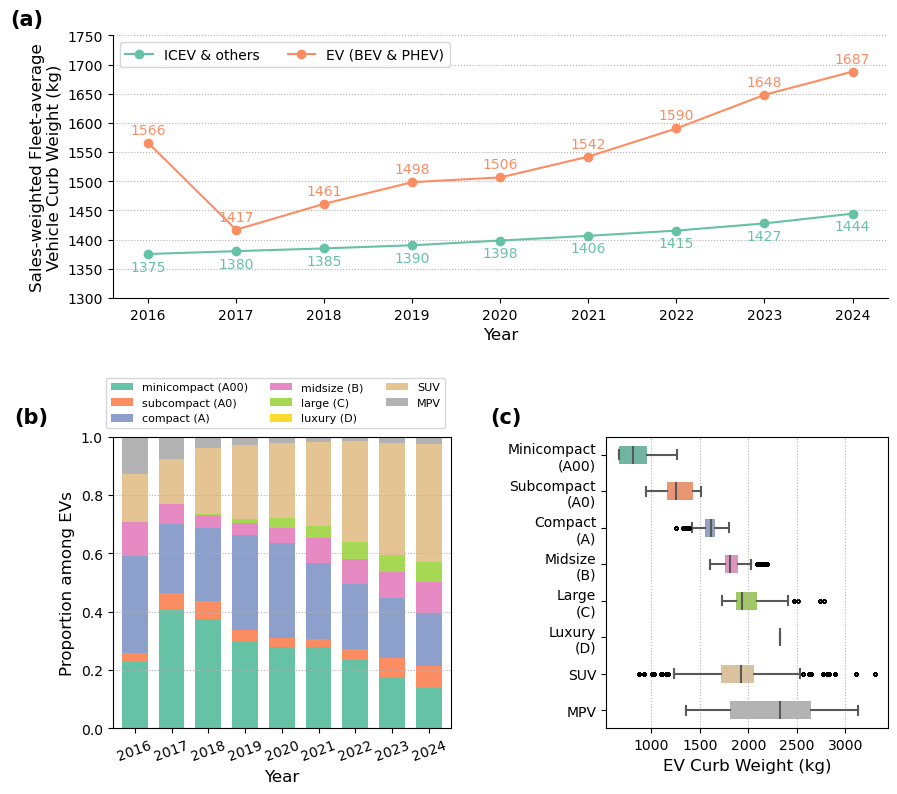

In [ ]:
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

# Create a figure with three subplots
fig = plt.figure(figsize=(10, 9))
gs = GridSpec(2, 2, figure=fig, width_ratios=[1.2, 1], height_ratios=[0.9, 1], wspace=0.5, hspace=0.5)

##########################################################
# First subplot: Trend of average vehicle weight by type
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(weights['year']))
# Set colors
set2_cmap = cm.get_cmap('Set2')
ICEV_color = set2_cmap(0)
EV_color = set2_cmap(1)
# plot
ax1.plot(x, weights['ICEV & others'], 'o-', color=ICEV_color, label='ICEV & others')
ax1.plot(x, weights['EV'], 'o-', color=EV_color, label='EV (BEV & PHEV)')

# Add data labels
for xi, yi in zip(x, weights['ICEV & others']):
    ax1.text(xi, yi-10, '%d'%yi, ha='center', va='top', color=ICEV_color, fontsize=10)
for xi, yi in zip(x, weights['EV']):
    ax1.text(xi, yi+10, '%d'%yi, ha='center', va='bottom', color=EV_color, fontsize=10)

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Sales-weighted Fleet-average\nVehicle Curb Weight (kg)', fontsize=12)
ax1.set_xticks(x, ["%d" % year for year in weights['year']])
ax1.set_ylim(1300, 1750)
ax1.grid(axis='y', linestyle=":")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend(loc='upper left', ncol=2)

##########################################################
# Second subplot: Proportion of EV vehicle classes
ax2 = fig.add_subplot(gs[1, 0])
# Pivot data
class_prop_pivot = ev_class_distribution.pivot(index='year', columns='class', values='proportion').fillna(0)
class_order = ['minicompact (A00)', 'subcompact (A0)', 'compact (A)', 'midsize (B)', 'large (C)', 'luxury (D)', 'SUV', 'MPV']
class_prop_pivot = class_prop_pivot[class_order]

# Plot stacked bar chart
bars = class_prop_pivot.plot(kind='bar', width=0.7, stacked=True, ax=ax2, colormap='Set2')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Proportion among EVs', fontsize=12)
ax2.set_xticks(x, ["%d" % year for year in weights['year']], rotation=20)
ax2.set_ylim(0, 1)
ax2.grid(axis='y', linestyle=":")
ax2.legend(loc='upper right', ncols=3, fontsize=8, bbox_to_anchor=(1.0, 1.22))

##########################################################
# Third subplot: Curb weight distribution by vehicle class
ax3 = fig.add_subplot(gs[1, 1])
# Filter EV types
ev_expanded = expanded_sales[expanded_sales['fuel'].isin(['BEV', 'PHEV'])]

sns.boxplot(
    ax=ax3,
    data=ev_expanded,
    y='class',
    x='weight',
    width=0.5, 
    orient='h',
    order=class_order,
    palette='Set2',
    showfliers=True,
    flierprops=flierprops,
    boxprops=dict(edgecolor='none', linewidth=0)
)

# Simplify y-axis labels
ax3.set_yticklabels(['Minicompact\n(A00)', 'Subcompact\n(A0)', 'Compact\n(A)', 'Midsize\n(B)', 'Large\n(C)', 'Luxury\n(D)', 'SUV', 'MPV'])
ax3.set_xlabel('EV Curb Weight (kg)', fontsize=12)
ax3.set_ylabel('')
ax3.grid(axis='x', linestyle=":")

# Add subplot labels
ax1.text(-0.09, 1.1, '(a)', transform=ax1.transAxes, size=15, fontweight='bold', va='top', ha='right')
ax2.text(-0.19, 1.1, '(b)', transform=ax2.transAxes, size=15, fontweight='bold', va='top', ha='right')
ax3.text(-0.3, 1.1, '(c)', transform=ax3.transAxes, size=15, fontweight='bold', va='top', ha='right')


# Adjust layout
plt.tight_layout()

plt.show()
# fig.savefig('figures/vehicle weights.jpg', bbox_inches='tight', dpi=1000)

### Brake Type

In [8]:
brake_types = pd.DataFrame({
    'year': annual_fleets.keys(),
    'ICEV frontB disc': [annual_fleets[year]['ICEV']['frontB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'ICEV frontB drum': [annual_fleets[year]['ICEV']['frontB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
    'ICEV rearB disc': [annual_fleets[year]['ICEV']['rearB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'ICEV rearB drum': [annual_fleets[year]['ICEV']['rearB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
    'BEV frontB disc': [annual_fleets[year]['BEV']['frontB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'BEV frontB drum': [annual_fleets[year]['BEV']['frontB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
    'BEV rearB disc': [annual_fleets[year]['BEV']['rearB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'BEV rearB drum': [annual_fleets[year]['BEV']['rearB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
    'PHEV frontB disc': [annual_fleets[year]['PHEV']['frontB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'PHEV frontB drum': [annual_fleets[year]['PHEV']['frontB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
    'PHEV rearB disc': [annual_fleets[year]['PHEV']['rearB'].replace('ventiled', 'disc').value_counts().get('disc', 0) for year in annual_fleets.keys()],
    'PHEV rearB drum': [annual_fleets[year]['PHEV']['rearB'].replace('ventiled', 'disc').value_counts().get('drum', 0) for year in annual_fleets.keys()],
})

In [9]:
# ICEV
brake_types['ICEV frontB disc%'] = brake_types['ICEV frontB disc'] / (brake_types['ICEV frontB disc'] + brake_types['ICEV frontB drum'])
brake_types['ICEV frontB drum%'] = brake_types['ICEV frontB drum'] / (brake_types['ICEV frontB disc'] + brake_types['ICEV frontB drum'])
brake_types['ICEV rearB disc%'] = brake_types['ICEV rearB disc'] / (brake_types['ICEV rearB disc'] + brake_types['ICEV rearB drum'])
brake_types['ICEV rearB drum%'] = brake_types['ICEV rearB drum'] / (brake_types['ICEV rearB disc'] + brake_types['ICEV rearB drum'])

# EV
brake_types['EV frontB disc'] = brake_types['BEV frontB disc'] + brake_types['PHEV frontB disc']
brake_types['EV frontB drum'] = brake_types['BEV frontB drum'] + brake_types['PHEV frontB drum']
brake_types['EV rearB disc'] = brake_types['BEV rearB disc'] + brake_types['PHEV rearB disc']
brake_types['EV rearB drum'] = brake_types['BEV rearB drum'] + brake_types['PHEV rearB drum']

brake_types['EV frontB disc%'] = brake_types['EV frontB disc'] / (brake_types['EV frontB disc'] + brake_types['EV frontB drum'])
brake_types['EV frontB drum%'] = brake_types['EV frontB drum'] / (brake_types['EV frontB disc'] + brake_types['EV frontB drum'])
brake_types['EV rearB disc%'] = brake_types['EV rearB disc'] / (brake_types['EV rearB disc'] + brake_types['EV rearB drum'])
brake_types['EV rearB drum%'] = brake_types['EV rearB drum'] /  (brake_types['EV rearB disc'] + brake_types['EV rearB drum'])

brake_types = brake_types[['year', 'ICEV frontB disc%', 'ICEV frontB drum%', 'ICEV rearB disc%', 'ICEV rearB drum%',
                           'EV frontB disc%', 'EV frontB drum%', 'EV rearB disc%', 'EV rearB drum%']]
brake_types

,year,ICEV frontB disc%,ICEV frontB drum%,ICEV rearB disc%,ICEV rearB drum%,EV frontB disc%,EV frontB drum%,EV rearB disc%,EV rearB drum%
0,2016,1.0,0.0,0.660112,0.339888,1.0,0.0,0.827082,0.172918
1,2017,1.0,0.0,0.680204,0.319796,1.0,0.0,0.680978,0.319022
2,2018,1.0,0.0,0.698088,0.301912,1.0,0.0,0.682275,0.317725
3,2019,1.0,0.0,0.713731,0.286269,1.0,0.0,0.761131,0.238869
4,2020,1.0,0.0,0.730997,0.269003,1.0,0.0,0.785978,0.214022
5,2021,1.0,0.0,0.748664,0.251336,1.0,0.0,0.766969,0.233031
6,2022,1.0,0.0,0.765965,0.234035,1.0,0.0,0.790098,0.209902
7,2023,1.0,0.0,0.782884,0.217116,1.0,0.0,0.829947,0.170053
8,2024,1.0,0.0,0.802243,0.197757,1.0,0.0,0.861754,0.138246


In [ ]:
# brake_types.to_csv('data/brake_types_2016_2024.csv', index=False)

In [10]:
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 800

import matplotlib.cm as cm
set2_colors = cm.get_cmap('Set2')

C:\Users\Ricky Chen\AppData\Local\Temp\ipykernel_23636\1923003504.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set2_colors = cm.get_cmap('Set2')


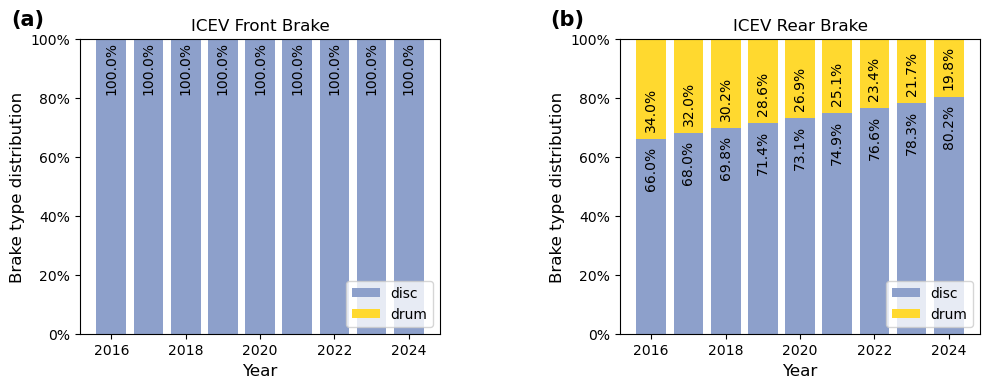

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4))
(ax1, ax2) = axes.flatten()

# colors
color_disc = set2_colors(2)
color_drum = set2_colors(5)

# Add panel labels in Nature style (top-left corner, bold)
ax1.text(-0.1, 1.1, '(a)', transform=ax1.transAxes, 
         fontsize=15, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, '(b)', transform=ax2.transAxes, 
         fontsize=15, fontweight='bold', va='top', ha='right')

## 1 ICEV front brake
years = brake_types['year']
icev_front_disc = brake_types['ICEV frontB disc%']
icev_front_drum = brake_types['ICEV frontB drum%']
icev_front_disc_bar = ax1.bar(years, icev_front_disc, label='disc', color=color_disc)
icev_front_drum_bar = ax1.bar(years, icev_front_drum, bottom=icev_front_disc, label='drum', color=color_drum)
ax1.legend(loc='lower right')
ax1.set_title('ICEV Front Brake')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Brake type distribution', fontsize=12)
ax1.set_ylim(0, 1)
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

## 2 ICEV rear brake
years = brake_types['year']
icev_rear_disc = brake_types['ICEV rearB disc%']
icev_rear_drum = brake_types['ICEV rearB drum%']
icev_rear_disc_bar = ax2.bar(years, icev_rear_disc, label='disc', color=color_disc)
icev_rear_drum_bar = ax2.bar(years, icev_rear_drum, bottom=icev_rear_disc, label='drum', color=color_drum)
ax2.legend(loc='lower right')
ax2.set_title('ICEV Rear Brake')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Brake type distribution', fontsize=12)
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# Add annotations for each bar segment
def add_annotations(ax, bars, bottom_bars=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # If there's bottom bars (for stacked segments), use their heights as offset
        y_offset = bottom_bars[i].get_height() if bottom_bars else 0
        # Calculate center position of each bar segment
        y_pos = y_offset + 0.1 if y_offset else y_offset + height - 0.1
        # Skip annotation if value is too small
        if height < 0.05:  # 5% threshold
            continue
        ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                f'{height*100:.1f}%', 
                ha='center', va='center', color='k', fontsize=10, rotation=90)

add_annotations(ax1, icev_front_disc_bar)
add_annotations(ax1, icev_front_drum_bar, icev_front_disc_bar)
add_annotations(ax2, icev_rear_disc_bar)
add_annotations(ax2, icev_rear_drum_bar, icev_rear_disc_bar)

# Adjust layout and display
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

# Save the figure if needed
# fig.savefig('figures/icev brake type.jpg', bbox_inches='tight', dpi=1000)

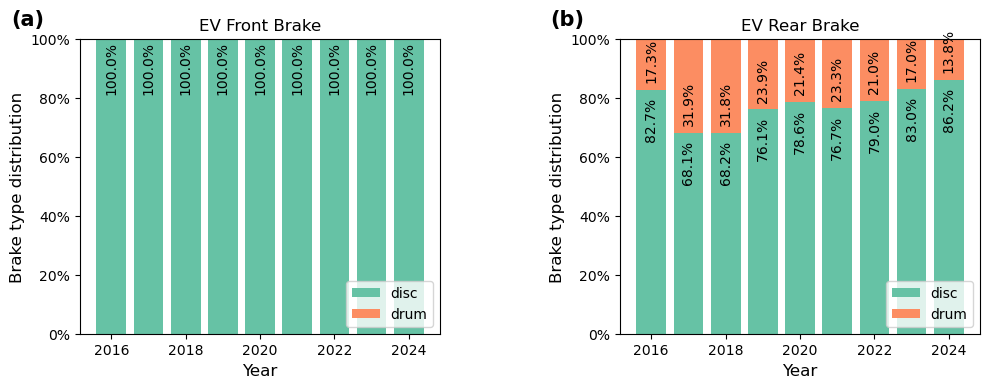

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10,4))
(ax1, ax2) = axes.flatten()

# colors
color_disc = set2_colors(0)
color_drum = set2_colors(1)

# Add panel labels in Nature style (top-left corner, bold)
ax1.text(-0.1, 1.1, '(a)', transform=ax1.transAxes, 
         fontsize=15, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, '(b)', transform=ax2.transAxes, 
         fontsize=15, fontweight='bold', va='top', ha='right')

## 1 EV front brake
years = brake_types['year']
ev_front_disc = brake_types['EV frontB disc%']
ev_front_drum = brake_types['EV frontB drum%']
ev_front_disc_bar = ax1.bar(years, ev_front_disc, label='disc', color=color_disc)
ev_front_drum_bar = ax1.bar(years, ev_front_drum, bottom=ev_front_disc, label='drum', color=color_drum)
ax1.legend(loc='lower right')
ax1.set_title('EV Front Brake')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Brake type distribution', fontsize=12)
ax1.set_ylim(0, 1)
ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

## 2 EV rear brake
years = brake_types['year']
ev_rear_disc = brake_types['EV rearB disc%']
ev_rear_drum = brake_types['EV rearB drum%']
ev_rear_disc_bar = ax2.bar(years, ev_rear_disc, label='disc', color=color_disc)
ev_rear_drum_bar = ax2.bar(years, ev_rear_drum, bottom=ev_rear_disc, label='drum', color=color_drum)
ax2.legend(loc='lower right')
ax2.set_title('EV Rear Brake')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Brake type distribution', fontsize=12)
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# Add annotations for each bar segment
def add_annotations(ax, bars, bottom_bars=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # If there's bottom bars (for stacked segments), use their heights as offset
        y_offset = bottom_bars[i].get_height() if bottom_bars else 0
        # Calculate center position of each bar segment
        y_pos = y_offset + 0.1 if y_offset else y_offset + height - 0.1
        # Skip annotation if value is too small
        if height < 0.05:  # 5% threshold
            continue
        ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                f'{height*100:.1f}%', 
                ha='center', va='center', color='k', fontsize=10, rotation=90)

add_annotations(ax1, ev_front_disc_bar)
add_annotations(ax1, ev_front_drum_bar, ev_front_disc_bar)
add_annotations(ax2, ev_rear_disc_bar)
add_annotations(ax2, ev_rear_drum_bar, ev_rear_disc_bar)

# Adjust layout and display
plt.tight_layout()
fig.subplots_adjust(wspace=0.5)
plt.show()

# Save the figure if needed
# fig.savefig('figures/ev brake type.jpg', bbox_inches='tight', dpi=1000)

---

### * HEV and REEV

In [29]:
sales = pd.read_excel('data/car_sales_2007_2024_calibration.xlsx')
sales = sales[['year', 'model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB']].copy()

# Fill missing values in 'weight' based on mean for the same year, fuel, and class
sales['weight'] = sales.groupby(['year', 'fuel', 'class'])['weight'].transform(lambda x: x.fillna(x.mean()))
sales.dropna(subset=['model', 'weight'], inplace=True)

In [30]:
# expand according to sales
expanded_data = []
for index, row in sales.iterrows():
    expanded_data.extend([(row['model'], row['sales'], row['class'], row['fuel'], row['weight'], row['frontB'], row['rearB'], row['year'])] * int(row['sales'] / 100))
expanded_sales = pd.DataFrame(expanded_data, columns=['model', 'sales', 'class', 'fuel', 'weight', 'frontB', 'rearB', 'year'])

#### Sales

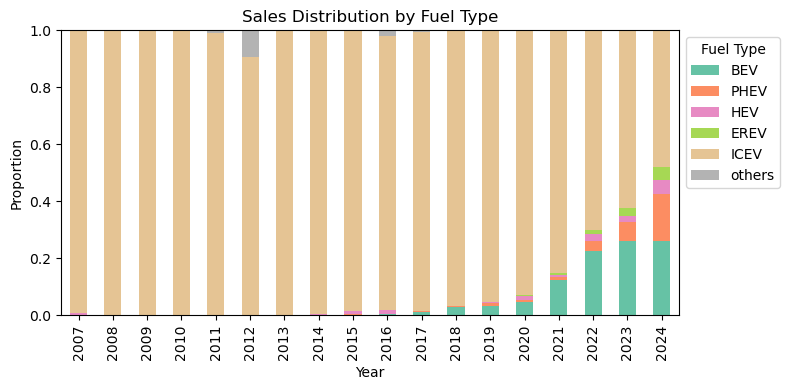

In [31]:
# Normalize to proportions
fuel_type_data = expanded_sales.groupby(['year', 'fuel']).size().unstack(fill_value=0)
fuel_type_data_normalized = fuel_type_data.div(fuel_type_data.sum(axis=1), axis=0)
fuel_type_data_normalized = fuel_type_data_normalized[['BEV', 'PHEV', 'HEV', 'EREV', 'ICEV', 'others']]

# Plot the stacked barplot
fuel_type_data_normalized.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2', fig=(8, 3))
plt.title('Sales Distribution by Fuel Type')
plt.xlabel('Year')
plt.ylim(0,1)
plt.ylabel('Proportion')
plt.legend(title='Fuel Type', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### Fleet

In [32]:
# define annual fleets dictionary
annual_fleets = {year: None for year in range(2016, 2025)}

# for each year, filter the expanded_sales DataFrame
for year in range(2016, 2025):
    icev = expanded_sales[
        (expanded_sales['fuel'] == 'ICEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    bev = expanded_sales[
        (expanded_sales['fuel'] == 'BEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 6)
    ]
    phev = expanded_sales[
        (expanded_sales['fuel'] == 'PHEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    hev = expanded_sales[
        (expanded_sales['fuel'] == 'HEV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    erev = expanded_sales[
        (expanded_sales['fuel'] == 'EREV') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]
    others = expanded_sales[
        (expanded_sales['fuel'] == 'others') &
        (expanded_sales['year'] <= year) & 
        (expanded_sales['year'] > year - 13)
    ]

    annual_fleets[year] = {
        'ICEV': icev,
        'BEV': bev,
        'PHEV': phev,
        'HEV' : hev,
        'EREV': erev,
        'others': others,
    }

In [34]:
for year in annual_fleets.keys():
    HEV = annual_fleets[year]['HEV'].size
    EREV = annual_fleets[year]['EREV'].size
    others = annual_fleets[year]['others'].size
    ICEV = annual_fleets[year]['ICEV'].size
    BEV = annual_fleets[year]['BEV'].size
    PHEV = annual_fleets[year]['PHEV'].size
    print("%d : %.2f %%" % (year, (HEV + EREV) / (HEV + EREV + others + ICEV + BEV + PHEV) * 100), "HEV&EREV")

2016 : 0.44 % HEV&EREV
2017 : 0.41 % HEV&EREV
2018 : 0.39 % HEV&EREV
2019 : 0.39 % HEV&EREV
2020 : 0.46 % HEV&EREV
2021 : 0.52 % HEV&EREV
2022 : 0.79 % HEV&EREV
2023 : 1.12 % HEV&EREV
2024 : 1.83 % HEV&EREV
